In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
from dataloader_creator import CreatorDL
creator = CreatorDL(seed=42, bs=2048)

In [3]:
df_UNSW = creator.reader("NF-UNSW-NB15-v3")

df_train_UNSW, df_test_UNSW, df_val_UNSW = creator.splitter(df_UNSW)

train_loader_UNSW, test_loader_UNSW, val_loader_UNSW = creator.balancer(df_train_UNSW, df_test_UNSW, df_val_UNSW)

Processando a categoria: 'Benign'
  -> Treino: 1118865 | Teste: 559433 | Validação: 559433
Processando a categoria: 'Fuzzers'
  -> Treino: 16908 | Teste: 8454 | Validação: 8454
Processando a categoria: 'Exploits'
  -> Treino: 21374 | Teste: 10687 | Validação: 10687
Processando a categoria: 'Backdoor'
  -> Treino: 2329 | Teste: 1165 | Validação: 1165
Processando a categoria: 'Reconnaissance'
  -> Treino: 8537 | Teste: 4268 | Validação: 4269
Processando a categoria: 'Generic'
  -> Treino: 9825 | Teste: 4913 | Validação: 4913
Processando a categoria: 'DoS'
  -> Treino: 2990 | Teste: 1495 | Validação: 1495
Processando a categoria: 'Shellcode'
  -> Treino: 1190 | Teste: 595 | Validação: 596
Processando a categoria: 'Analysis'
  -> Treino: 613 | Teste: 306 | Validação: 307
Processando a categoria: 'Worms'
  -> Treino: 79 | Teste: 39 | Validação: 40

--- Base de Treino ---
Tamanho: 1182710 linhas
Categorias presentes: ['Benign' 'Exploits' 'Reconnaissance' 'Fuzzers' 'DoS' 'Generic' 'Backdoor'


In [4]:
df_BOT= creator.reader("NF-BoT-IoT-v3")

df_train_BOT, df_test_BOT, df_val_BOT = creator.splitter(df_BOT)

train_loader_BOT, test_loader_BOT, val_loader_BOT = creator.balancer(df_train_BOT, df_test_BOT, df_val_BOT)

Processando a categoria: 'Benign'
  -> Treino: 25994 | Teste: 12997 | Validação: 12998
Processando a categoria: 'DDoS'
  -> Treino: 3575441 | Teste: 1787720 | Validação: 1787721
Processando a categoria: 'DoS'
  -> Treino: 4017095 | Teste: 2008547 | Validação: 2008548
Processando a categoria: 'Reconnaissance'
  -> Treino: 847566 | Teste: 423783 | Validação: 423783
Processando a categoria: 'Theft'
  -> Treino: 807 | Teste: 404 | Validação: 404

--- Base de Treino ---
Tamanho: 8466903 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               4017095
DDoS              3575441
Reconnaissance     847566
Benign              25994
Theft                 807
Name: count, dtype: int64
-------------------------

--- Base de Teste ---
Tamanho: 4233451 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               2008547
DDoS              1787720
Reconnaissance     423783
Benign              12997
Theft            

In [5]:
df_CIC= creator.reader("NF-CICIDS2018-v3")

df_train_CIC, df_test_CIC, df_val_CIC = creator.splitter(df_CIC)

train_loader_CIC, test_loader_CIC, val_loader_CIC = creator.balancer(df_train_CIC, df_test_CIC, df_val_CIC)

Processando a categoria: 'Benign'
  -> Treino: 8757313 | Teste: 4378656 | Validação: 4378657
Processando a categoria: 'FTP-BruteForce'
  -> Treino: 193360 | Teste: 96680 | Validação: 96680
Processando a categoria: 'SSH-Bruteforce'
  -> Treino: 94237 | Teste: 47118 | Validação: 47119
Processando a categoria: 'DoS_attacks-GoldenEye'
  -> Treino: 30650 | Teste: 15325 | Validação: 15325
Processando a categoria: 'DoS_attacks-Slowloris'
  -> Treino: 18020 | Teste: 9010 | Validação: 9010
Processando a categoria: 'DoS_attacks-SlowHTTPTest'
  -> Treino: 52775 | Teste: 26387 | Validação: 26388
Processando a categoria: 'DoS_attacks-Hulk'
  -> Treino: 50038 | Teste: 25019 | Validação: 25019
Processando a categoria: 'DDoS_attacks-LOIC-HTTP'
  -> Treino: 144294 | Teste: 72147 | Validação: 72148
Processando a categoria: 'DDOS_attack-LOIC-UDP'
  -> Treino: 1725 | Teste: 862 | Validação: 863
Processando a categoria: 'DDOS_attack-HOIC'
  -> Treino: 516155 | Teste: 258078 | Validação: 258078
Processando 

In [6]:
train_loaders = [train_loader_UNSW, train_loader_BOT, train_loader_CIC]
test_loaders = [test_loader_UNSW, test_loader_BOT, test_loader_CIC]
val_loaders = [val_loader_UNSW, val_loader_BOT, val_loader_CIC]

In [54]:
INPUT_DIM = 32

class IDSBranchyNet(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, num_classes=2):
        super(IDSBranchyNet, self).__init__()
        
        self.alpha = nn.Parameter(torch.tensor([4.0])) 

        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.ReLU(),
        )
        
        self.exit1_layers = nn.Sequential(
            nn.Linear(input_dim * 2, num_classes)
        )
        
        self.exit2_layers = nn.Sequential(
            nn.Linear(input_dim * 2, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 2048),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

    def get_threshold(self):
        return torch.sigmoid(self.alpha)

    def forward_exit1(self, x):
        features = self.shared_layers(x)
        return self.exit1_layers(features)

    def forward_exit2(self, x):
        features = self.shared_layers(x)
        return self.exit2_layers(features)

model = IDSBranchyNet()

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [56]:
def train_model(model, train_loaders_dict, val_loader_dict, epochs, lr, device, patience=15):
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    sigmoid = nn.Sigmoid()  

    metrics = [
        'loss1_a', 'loss1_b', 'loss1_c', 'loss_ex1_avg',
        'loss2_a', 'loss2_b', 'loss2_c', 'loss_ex2_avg',
        'l_joint', 'total_loss'
    ]

    history = {
        'train': {k: [] for k in metrics},
        'val': {k: [] for k in metrics}
    }

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        
        running_metrics = {k: 0.0 for k in metrics}
        total_steps = 0
                
        for (inputs_a, labels_a), (inputs_b, labels_b), (inputs_c, labels_c) in zip(train_loaders_dict[0], train_loaders_dict[1], train_loaders_dict[2]):
            optimizer.zero_grad()

            current_threshold = model.get_threshold()
            
            inputs_a, labels_a = inputs_a.to(device), labels_a.to(device)
            inputs_b, labels_b = inputs_b.to(device), labels_b.to(device)
            inputs_c, labels_c = inputs_c.to(device), labels_c.to(device)
            total_samples = inputs_a.size(0) + inputs_b.size(0) + inputs_c.size(0)

            out1_a = model.forward_exit1(inputs_a)
            out1_b = model.forward_exit1(inputs_b)
            out1_c = model.forward_exit1(inputs_c)

            loss1_a = criterion(out1_a, labels_a)
            loss1_b = criterion(out1_b, labels_b)
            loss1_c = criterion(out1_c, labels_c)
            loss_ex1_avg = (loss1_a + loss1_b + loss1_c) / 3

            curr_thresh_val = current_threshold.item()
            
            probs_a = F.softmax(out1_a, dim=1)
            conf_a, _ = torch.max(probs_a, dim=1)
            mask_a = conf_a < curr_thresh_val

            probs_b = F.softmax(out1_b, dim=1)
            conf_b, _ = torch.max(probs_b, dim=1)
            mask_b = conf_b < curr_thresh_val

            probs_c = F.softmax(out1_c, dim=1)
            conf_c, _ = torch.max(probs_c, dim=1)
            mask_c = conf_c < curr_thresh_val

            k = 10
            prob_exit2_a = sigmoid(k * (current_threshold - conf_a))
            prob_exit2_b = sigmoid(k * (current_threshold - conf_b))
            prob_exit2_c = sigmoid(k * (current_threshold - conf_c))
            soft_count_exit2 = torch.sum(prob_exit2_a) + torch.sum(prob_exit2_b) + torch.sum(prob_exit2_c)

            loss2_a = torch.tensor(0.0, device=device)
            loss2_b = torch.tensor(0.0, device=device)
            loss2_c = torch.tensor(0.0, device=device)

            if mask_a.any():
                loss2_a = criterion(model.forward_exit2(inputs_a[mask_a]), labels_a[mask_a])
            if mask_b.any():
                loss2_b = criterion(model.forward_exit2(inputs_b[mask_b]), labels_b[mask_b])
            if mask_c.any():
                loss2_c = criterion(model.forward_exit2(inputs_c[mask_c]), labels_c[mask_c])

            loss_ex2_avg = (loss2_a + loss2_b + loss2_c) / 3

            l_joint = loss_ex1_avg + loss_ex2_avg
            total_loss = l_joint + 0.5 * (soft_count_exit2 / total_samples)

            total_loss.backward()
            optimizer.step()

            running_metrics['loss1_a'] += loss1_a.item()
            running_metrics['loss1_b'] += loss1_b.item()
            running_metrics['loss1_c'] += loss1_c.item()
            running_metrics['loss_ex1_avg'] += loss_ex1_avg.item()
            
            running_metrics['loss2_a'] += loss2_a.item()
            running_metrics['loss2_b'] += loss2_b.item()
            running_metrics['loss2_c'] += loss2_c.item()
            running_metrics['loss_ex2_avg'] += loss_ex2_avg.item()
            
            running_metrics['l_joint'] += l_joint.item()
            running_metrics['total_loss'] += total_loss.item()
            
            total_steps += 1

        for k in metrics:
            history['train'][k].append(running_metrics[k] / total_steps)
        
        epoch_train_loss = history['train']['total_loss'][-1]

        model.eval()
        running_metrics_val = {k: 0.0 for k in metrics}
        total_steps_val = 0
        
        with torch.no_grad():
            current_threshold = model.get_threshold()
            curr_thresh_val = current_threshold.item()

            for (inputs_a, labels_a), (inputs_b, labels_b), (inputs_c, labels_c) in zip(val_loader_dict[0], val_loader_dict[1], val_loader_dict[2]):
                inputs_a, labels_a = inputs_a.to(device), labels_a.to(device)
                inputs_b, labels_b = inputs_b.to(device), labels_b.to(device)
                inputs_c, labels_c = inputs_c.to(device), labels_c.to(device)
                total_samples = inputs_a.size(0) + inputs_b.size(0) + inputs_c.size(0)
    
                out1_a = model.forward_exit1(inputs_a)
                out1_b = model.forward_exit1(inputs_b)
                out1_c = model.forward_exit1(inputs_c)
    
                loss1_a = criterion(out1_a, labels_a)
                loss1_b = criterion(out1_b, labels_b)
                loss1_c = criterion(out1_c, labels_c)
                loss_ex1_avg = (loss1_a + loss1_b + loss1_c) / 3
    
                probs_a = F.softmax(out1_a, dim=1)
                mask_a = torch.max(probs_a, dim=1)[0] < curr_thresh_val
                probs_b = F.softmax(out1_b, dim=1)
                mask_b = torch.max(probs_b, dim=1)[0] < curr_thresh_val
                probs_c = F.softmax(out1_c, dim=1)
                mask_c = torch.max(probs_c, dim=1)[0] < curr_thresh_val
                
                real_count_exit2 = mask_a.sum() + mask_b.sum() + mask_c.sum()
    
                loss2_a = torch.tensor(0.0, device=device)
                loss2_b = torch.tensor(0.0, device=device)
                loss2_c = torch.tensor(0.0, device=device)
    
                if mask_a.any(): loss2_a = criterion(model.forward_exit2(inputs_a[mask_a]), labels_a[mask_a])
                if mask_b.any(): loss2_b = criterion(model.forward_exit2(inputs_b[mask_b]), labels_b[mask_b])
                if mask_c.any(): loss2_c = criterion(model.forward_exit2(inputs_c[mask_c]), labels_c[mask_c])
    
                loss_ex2_avg = (loss2_a + loss2_b + loss2_c) / 3
    
                total_loss = l_joint + 0.5 * (real_count_exit2 / total_samples)
                
                running_metrics_val['loss1_a'] += loss1_a.item()
                running_metrics_val['loss1_b'] += loss1_b.item()
                running_metrics_val['loss1_c'] += loss1_c.item()
                running_metrics_val['loss_ex1_avg'] += loss_ex1_avg.item()
                
                running_metrics_val['loss2_a'] += loss2_a.item()
                running_metrics_val['loss2_b'] += loss2_b.item()
                running_metrics_val['loss2_c'] += loss2_c.item()
                running_metrics_val['loss_ex2_avg'] += loss_ex2_avg.item()
                
                running_metrics_val['l_joint'] += l_joint.item()
                running_metrics_val['total_loss'] += total_loss.item()
                
                total_steps_val += 1

        for k in metrics:
            history['val'][k].append(running_metrics_val[k] / total_steps_val)

        epoch_val_loss = history['val']['total_loss'][-1]

        print(f'Epoch [{epoch+1}/{epochs}] | Train Total: {epoch_train_loss:.4f} | Val Total: {epoch_val_loss:.4f} | Alpha: {curr_thresh_val}')
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping...")
                if best_model_state: model.load_state_dict(best_model_state)
                break

    epochs_range = range(1, len(history['train']['total_loss']) + 1)
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    
    ax = axs[0]
    ax.set_title("Exit 1")
    ax.plot(epochs_range, history['train']['loss1_a'], label='Tr A', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss1_b'], label='Tr B', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss1_c'], label='Tr C', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss_ex1_avg'], label='Tr Avg', linewidth=2)
    
    ax.plot(epochs_range, history['val']['loss1_a'], label='Val A', color='black', linestyle='--')
    ax.plot(epochs_range, history['val']['loss1_b'], label='Val B', color='black', linestyle='--')
    ax.plot(epochs_range, history['val']['loss1_c'], label='Val C', color='black', linestyle='--')
    ax.plot(epochs_range, history['val']['loss_ex1_avg'], label='Val Avg', color='black', linestyle='--', linewidth=2)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

    ax = axs[1]
    ax.set_title("Exit 2")
    ax.plot(epochs_range, history['train']['loss2_a'], label='Tr A', color='blue', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss2_b'], label='Tr B', color='green', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss2_c'], label='Tr C', color='red', alpha=0.6)
    ax.plot(epochs_range, history['train']['loss_ex2_avg'], label='Tr Avg', color='black', linewidth=2)
    
    ax.plot(epochs_range, history['val']['loss2_a'], label='Val A', color='black', linestyle='--')
    ax.plot(epochs_range, history['val']['loss2_b'], label='Val B', color='black', linestyle='--')
    ax.plot(epochs_range, history['val']['loss2_c'], label='Val C', color='black', linestyle='--')
    ax.plot(epochs_range, history['val']['loss_ex2_avg'], label='Val Avg', color='black', linestyle='--', linewidth=2)
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.grid(True)

    ax = axs[2]
    ax.set_title("Global Optimization")
    ax.plot(epochs_range, history['train']['l_joint'], label='Tr Joint (Ex1 + Ex2)', color='purple')
    ax.plot(epochs_range, history['train']['total_loss'], label='Tr Total (Joint + (NEx2 / N))', color='orange', linewidth=2)
    
    ax.plot(epochs_range, history['val']['l_joint'], label='Val Joint', color='purple', linestyle='--')
    ax.plot(epochs_range, history['val']['total_loss'], label='Val Total', color='orange', linestyle='--', linewidth=2)
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()
    
    return curr_thresh_val

In [57]:
def evaluate_model(model, loader, confidence_threshold, device):
    model.to(device)
    model.eval()

    total_samples = len(loader.dataset)
    all_predictions = []
    all_labels = []
    exited_early_count = 0
    total_inference_time = 0

    with torch.no_grad():
        for samples, labels in loader:
            samples, labels = samples.to(device), labels.to(device)

            start_time = time.perf_counter()
            
            branch_output = model.forward_exit1(samples)
            
            branch_prob = F.softmax(branch_output, dim=1)
            trusts, branch_preds = torch.max(branch_prob, 1)

            batch_predictions = torch.zeros_like(labels)
            
            early_exit_mask = trusts > confidence_threshold
            
            if early_exit_mask.any():
                batch_predictions[early_exit_mask] = branch_preds[early_exit_mask]
                exited_early_count += early_exit_mask.sum().item()

            main_branch_mask = ~early_exit_mask
            if main_branch_mask.any():
                
                samples_to_main = samples[main_branch_mask]
                
                main_output = model.forward_exit2(samples_to_main)
                
                main_prob = F.softmax(main_output, dim=1)
                _, main_preds = torch.max(main_prob, 1)
                
                batch_predictions[main_branch_mask] = main_preds

            end_time = time.perf_counter()
            total_inference_time += (end_time - start_time)

            all_predictions.append(batch_predictions.cpu())
            all_labels.append(labels.cpu())

    final_predictions = torch.cat(all_predictions)
    y_data = torch.cat(all_labels)

    correct = (final_predictions == y_data).sum().item()
    accuracy = 100 * correct / total_samples
    exit_rate = 100 * exited_early_count / total_samples
    avg_time_ms = (total_inference_time / total_samples) * 1000

    cm = confusion_matrix(y_data.numpy(), final_predictions.numpy())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Ataque'],
                yticklabels=['Normal', 'Ataque'])
    plt.xlabel('Rótulo Previsto')
    plt.ylabel('Rótulo Verdadeiro')
    plt.title(f'Matriz de Confusão (Limiar de Confiança = {confidence_threshold})')
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    
    f1 = f1_score(y_data.numpy(), final_predictions.numpy())
    
    tpr = recall_score(y_data.numpy(), final_predictions.numpy())

    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}\n")
    
    print(f"F1 Score: {f1:.4f}")
    print(f"True Positive Rate (TPR) / Recall: {tpr:.4f}")
    print(f"True Negative Rate (TNR) / Specificity: {tnr:.4f}")

    return {
            'accuracy': accuracy,
            'exit_rate': exit_rate,
            'avg_inference_time_ms': avg_time_ms,
            'exited_early_count': exited_early_count,
            'total_samples': total_samples
        }

In [58]:
modelname = 'teste5'
modelname

'teste5'

Epoch [1/1000] | Train Total: 1.8839 | Val Total: 1.8880 | Alpha: 0.9820130467414856
Epoch [2/1000] | Train Total: 1.8836 | Val Total: 1.8879 | Alpha: 0.9820123910903931
Epoch [3/1000] | Train Total: 1.8832 | Val Total: 1.8872 | Alpha: 0.9820116758346558
Epoch [4/1000] | Train Total: 1.8830 | Val Total: 1.8870 | Alpha: 0.9820110201835632
Epoch [5/1000] | Train Total: 1.8827 | Val Total: 1.8868 | Alpha: 0.9820103049278259
Epoch [6/1000] | Train Total: 1.8822 | Val Total: 1.8859 | Alpha: 0.9820095300674438
Epoch [7/1000] | Train Total: 1.8820 | Val Total: 1.8861 | Alpha: 0.9820088148117065
Epoch [8/1000] | Train Total: 1.8814 | Val Total: 1.8853 | Alpha: 0.9820080995559692
Epoch [9/1000] | Train Total: 1.8809 | Val Total: 1.8849 | Alpha: 0.9820074439048767
Epoch [10/1000] | Train Total: 1.8805 | Val Total: 1.8841 | Alpha: 0.9820067286491394
Epoch [11/1000] | Train Total: 1.8798 | Val Total: 1.8834 | Alpha: 0.9820060729980469
Epoch [12/1000] | Train Total: 1.8790 | Val Total: 1.8830 | Alp

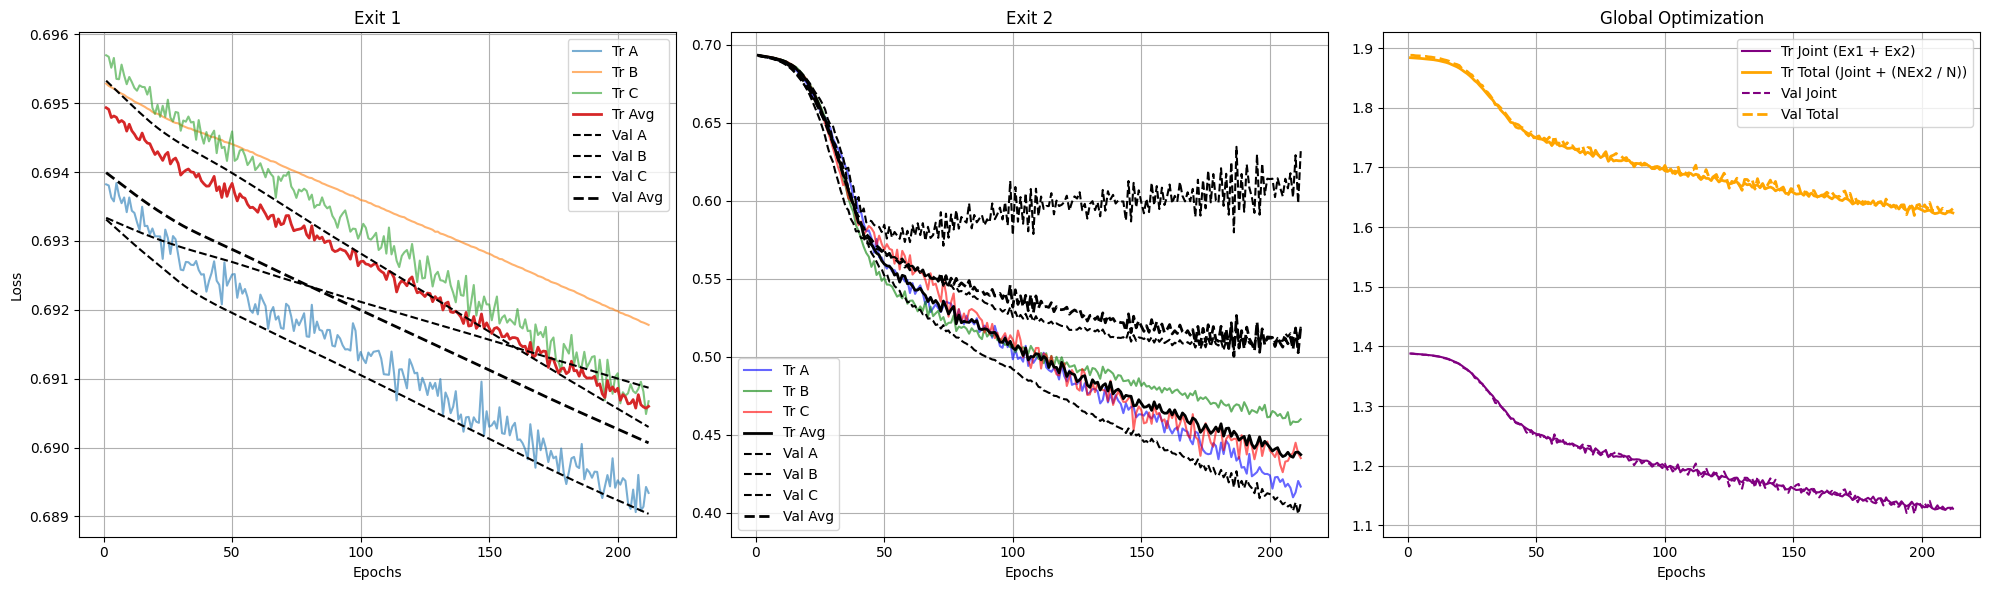


Modelo treinado e salvo em 'models/teste5.pth'


In [59]:
epochs = 1000

limiar = train_model(model, train_loaders, val_loaders, epochs, lr=0.00001, device=device)

torch.save(model.state_dict(), f'models/{modelname}.pth')
print(f"\nModelo treinado e salvo em 'models/{modelname}.pth'")

Modelo 'models/teste5.pth' carregado

Base: UNSW


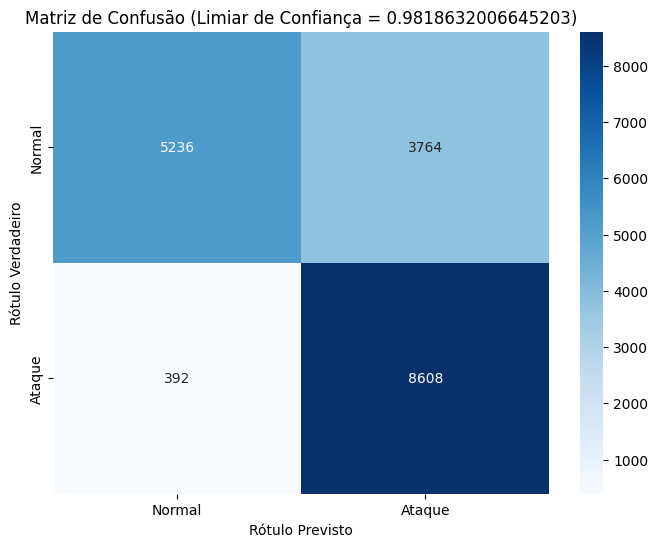

True Positives (TP): 8608
True Negatives (TN): 5236
False Positives (FP): 3764
False Negatives (FN): 392

F1 Score: 0.8055
True Positive Rate (TPR) / Recall: 0.9564
True Negative Rate (TNR) / Specificity: 0.5818
--------------------
  Accuracy: 76.9111%
  Avg. Inference Time: 0.0021 ms
  Early Exit Rate: 0.0000% (0/18000)
--------------------

Base: BOT


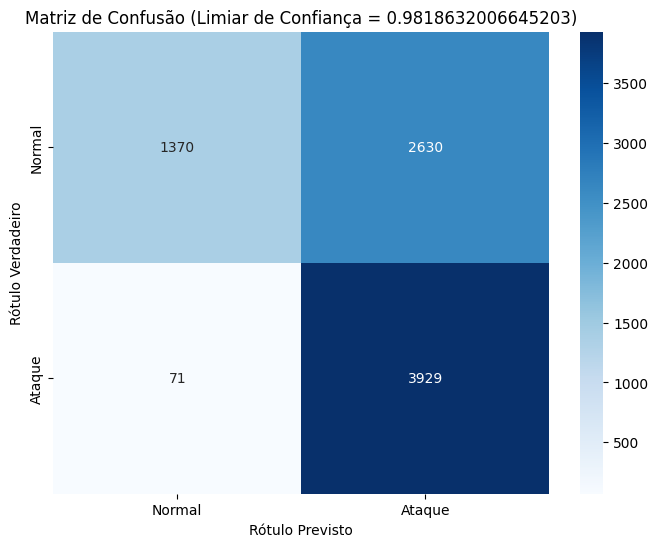

True Positives (TP): 3929
True Negatives (TN): 1370
False Positives (FP): 2630
False Negatives (FN): 71

F1 Score: 0.7442
True Positive Rate (TPR) / Recall: 0.9822
True Negative Rate (TNR) / Specificity: 0.3425
--------------------
  Accuracy: 66.2375%
  Avg. Inference Time: 0.0036 ms
  Early Exit Rate: 0.0000% (0/8000)
--------------------

Base: CIC


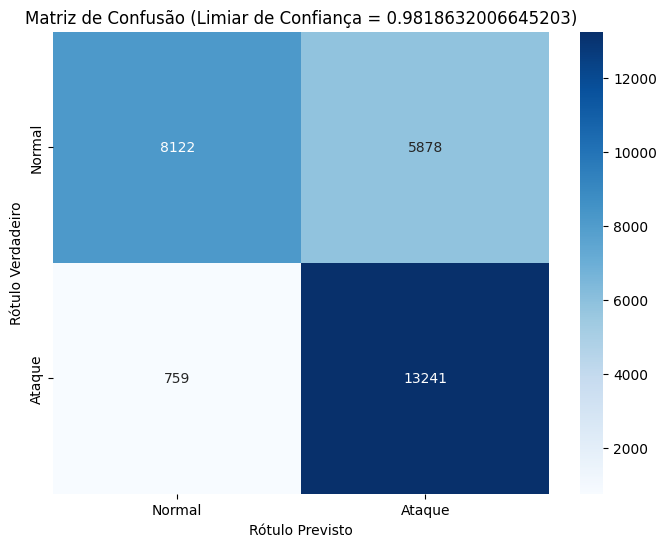

True Positives (TP): 13241
True Negatives (TN): 8122
False Positives (FP): 5878
False Negatives (FN): 759

F1 Score: 0.7996
True Positive Rate (TPR) / Recall: 0.9458
True Negative Rate (TNR) / Specificity: 0.5801
--------------------
  Accuracy: 76.2964%
  Avg. Inference Time: 0.0027 ms
  Early Exit Rate: 0.0000% (0/28000)
--------------------


In [60]:
model.load_state_dict(torch.load(f'models/{modelname}.pth'))
print(f"Modelo 'models/{modelname}.pth' carregado\n")

print(f"Base: UNSW")
results = evaluate_model(model, test_loaders[0], limiar, device=device)
print("-" * 20)
print(f"  Accuracy: {results['accuracy']:.4f}%")
print(f"  Avg. Inference Time: {results['avg_inference_time_ms']:.4f} ms")
print(f"  Early Exit Rate: {results['exit_rate']:.4f}% ({results['exited_early_count']}/{results['total_samples']})")
print("-" * 20)

print(f"\nBase: BOT")
results = evaluate_model(model, test_loaders[1], limiar, device=device)
print("-" * 20)
print(f"  Accuracy: {results['accuracy']:.4f}%")
print(f"  Avg. Inference Time: {results['avg_inference_time_ms']:.4f} ms")
print(f"  Early Exit Rate: {results['exit_rate']:.4f}% ({results['exited_early_count']}/{results['total_samples']})")
print("-" * 20)

print(f"\nBase: CIC")
results = evaluate_model(model, test_loaders[2], limiar, device=device)
print("-" * 20)
print(f"  Accuracy: {results['accuracy']:.4f}%")
print(f"  Avg. Inference Time: {results['avg_inference_time_ms']:.4f} ms")
print(f"  Early Exit Rate: {results['exit_rate']:.4f}% ({results['exited_early_count']}/{results['total_samples']})")
print("-" * 20)